# Evidence that investing in an index fund is a better bet than buying a home

For most people, the two main ways to build wealth are to buy a home or to invest in the stock market. How do you decide which approach to take for yourself? Can you find an optimal way to do both such as paying a mortgage while also putting money into a 401k? The answer is ultimately a personal decision based on your risk tolerance as well as details that are specific to your situation such as the mortgage rate available to you, the company match for investing in the 401k, your tax bracket, and the list goes on. Notably, a major factor in deciding to buy a home is location. As we will see below, homes in some states have appreciated in value far more than other states. In this notebook, I will use house price data from [St. Louis Fred](https://fred.stlouisfed.org/) to address the questions below.

1. Exploratory data analysis of the S&P 500 index and housing prices of all 50 states. What are the historical trends?
2. Which states outperformed the S&P 500?
3. How often has the S&P outcompeted the majority of housing markets?
4. Which states are least correlated with the S&P 500 and are therefore subject to less risk?

## Section 1: Exploratory data analysis

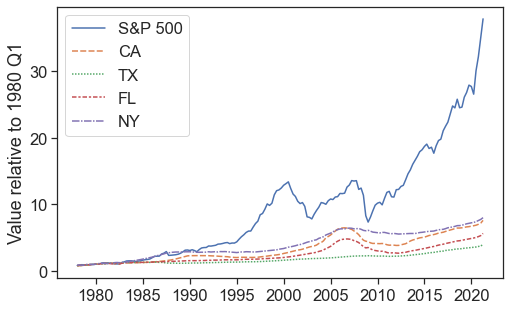

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from datetime import timedelta
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from sklearn import linear_model

#create a dataFrame from each file
mortgage_rates=pd.read_csv("MORTGAGE30US.csv",index_col=0)
mortgage_rates.index=pd.to_datetime(mortgage_rates.index)
US_median_price=pd.read_csv("US_median_home_price.csv",index_col=0)
US_median_price.index=pd.to_datetime(US_median_price.index)

#csv file has 5 columns. we only need the Open price
SP500_df=pd.read_csv('HistoricalPrices.csv',index_col=0,usecols=[0,1])
SP500_df.index=pd.to_datetime(SP500_df.index)
#sort chronologically, every business day is included
SP500_df.sort_index(inplace=True) 

#take average of each quarter to compare with the housing price index
SP500_q=SP500_df.resample('QS').mean()
#normalize to 1980 Q1, same as house price index
SP500_q=SP500_q/SP500_q[SP500_q.index==datetime(1980,1,1)].values

#load the names of csv files of the states
files=listdir("states/")
frames=[]
for f in files:
    #load the csv into a DataFrame
    frames.append(pd.read_csv('states/'+f,index_col=0))
#combine all frames into a single frame. 1980 Q1 is set to 1
states_HPI=frames[0].join(frames[1:])/100
#dates are the first day of each quarter
states_HPI.index=pd.to_datetime(states_HPI.index)
#rename all the state names without the HPI
#create a dict where the keys are the column names and the values are just the state abbrev
mapping={}
for state in states_HPI.columns:
    mapping[state]=state[:2]
states_HPI.rename(columns=mapping,inplace=True)
#create a new frame with all data as columns
df=SP500_q.join(states_HPI,how='inner')
#rename the column for clarity
df.rename(columns={' Open': 'S&P 500'},inplace=True)

#let's look at the 4 largest states in population
plt.figure(figsize=(8,5))
sns.lineplot(data=df[['S&P 500','CA','TX','FL','NY']])
plt.ylabel('Value relative to 1980 Q1')
plt.show()

## Trends: high risk, high reward
- Compared to the house price indices, the stock market index, S&P 500, has experienced the greatest growth and also the largest downturns such as the early 2000s and 2008-2009. In other words, there is greater risk in the stock market, but over periods of 30 years or longer, the stock market tends to increase. 
- Generally, the house prices for California, Texas, Florida, and New York have tended to increase over the last 40 years, but their growth is quite small compared to the S&P 500. 
- California, Florida, and New York house prices dipped in 2008 just like the stock market. Of these housing markets, Texas is the only one that was insulated from the recession. We can use our data set to determine which other states were unaffected by the 2008 recession as well as by other down turns in the past. Texas and those other states would be a way to mitigate risk.

#### Why use the S&P 500 index?
I use the S&P500 index as the method for stock investing because it is arguably the most effective strategy on time scales of decades or longer. For a detailed explanation, read _The Little Book of Common Sense Investing_ by John Bogle. Additionally, this index fund is very easy to use in a practical sense because many mutual funds and exchange-traded funds track this index and are readily available for any person to buy shares. For example, anyone can buy shares of Schwab S&P 500 Index Fund (SWPPX) or Vanguard S&P 500 ETF (VOO) (or other examples). By purchasing a share of SWPPX or VOO, you are effectively invested in all 500 of the most successful US companies. For a broad overview of index fund investing, I recommend _The Simple Path to Wealth_ by JL Collins.

#### How to compare RE and index investing
To make a valid comparison between these two strategies we will need to make the real estate scenario more concrete. Suppose we would want the following: 
- downpayment of 20% of the home value 
- we have \\$ 10k available for the downpayment 
- That means we would be looking for a house of \\$ 50k. For now, let's assume that in 1990, a good home could be found at this price in any state.
- fixed mortgage rate for 30 year term

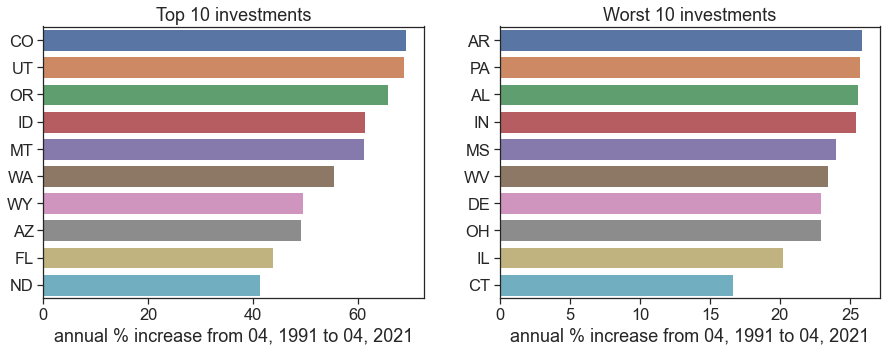

In [2]:

def calc_changes(df,start_date,final_date):
    """ Calculate the % change of each of the columns in a DataFrame
    INPUTS
    df: pandas dataframe with a datetime index
    start_time: datetime object
    final_date: datetime object
    OUTPUT
    changes: values are the percent change as a Series
    """
    if not(isinstance(start_date, datetime)): 
        if isinstance(start_date, str):
            #convert string to datetime
            start_date=datetime.strptime(start_date, '%Y-%m-%d')
        else:
            return -1
    if not(isinstance(final_date, datetime)):
        if isinstance(final_date, str):
            final_date=datetime.strptime(final_date, '%Y-%m-%d')
        else:
            return -1
    #select the closest values to the start date
    start_val=df[df.index>=start_date].iloc[0]
    stop_val=df[df.index>=final_date].iloc[0]
    #how much would the investment grow in each column?
    changes=(stop_val-start_val)/start_val
    n_years=final_date.year-start_date.year +(final_date.month-start_date.month)/12
    #convert DataFrame to a Series and change to percentage
    changes=changes.squeeze(axis=0)*100/n_years 
    changes.sort_values(inplace=True,ascending=False)
    #determine the average interest rate on a fixed, 30-year loan at the purchase time
    int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
    #real estate gains are relative to the downpayment, instead of the house value
    changes[1:]=changes[1:]*5-int_rate[0]/100 #substract the mortgage rate
    changes.sort_values(inplace=True,ascending=False)
    return changes

#choose the last date that's available
final_date=df.index[-1]
start_date=final_date.replace(year=final_date.year-30) #subtract 30 years
example1=calc_changes(df,start_date,final_date)
#show these changes in a bar plot
def plot_best_and_worst(for_plot,start_date,final_date,use_xlim=False):
    fig, ax=plt.subplots(1,2,figsize=(15,5))
    for_xaxis='annual % increase from '+start_date.strftime('%m, %Y')+' to '+final_date.strftime('%m, %Y')
    #only show the top 10
    sns.barplot(x=for_plot[:10],y=for_plot[:10].index,ax=ax[0],orient='h')
    ax[0].set_title('Top 10 investments')
    ax[0].set_xlabel(for_xaxis)
    if use_xlim:
        ax[0].set_xlim(0,40)
    sns.barplot(x=for_plot[-10:],y=for_plot[-10:].index,ax=ax[1],orient='h')
    ax[1].set_title('Worst 10 investments')
    ax[1].set_xlabel(for_xaxis)
    if use_xlim:
        ax[1].set_xlim(0,40)
    plt.show()
    

plot_best_and_worst(example1,start_date,final_date,False)

## Section 2: Which states outperformed the S&P 500?
### Homes in Colorado, Utah, and Oregon were the best investment decisions for 1991 to 2021
For the period from 1991 to 2021, the S&P 500 is not one of the top 10 or the worst 10 either. The best housing markets were Colorado, Utah, and Oregon. 

_Note_: The real estate gains are relative to the downpayment, instead of the house value, and I subtracted the mortgage rate. This comparison is not quite fair because the scenarios with a home purchase all assume the full repayment of the mortgage, whereas the nest egg in the index fund grew without _any_ additional payments and without dividends reinvested. With payments and dividends, the index fund would show a greater return on investment.

In [3]:
example1.loc[example1<example1['S&P 500']].index

Index(['NH', 'NE', 'LA', 'WI', 'ME', 'VA', 'NM', 'AK', 'NY', 'KS', 'SC', 'NC',
       'GA', 'IA', 'RI', 'OK', 'KY', 'VT', 'MO', 'NJ', 'HI', 'MD', 'MI', 'AR',
       'PA', 'AL', 'IN', 'MS', 'WV', 'DE', 'OH', 'IL', 'CT'],
      dtype='object')

In [4]:
sum(example1<example1['S&P 500'])

33

### The S&P 500 index outperforms the average home purchase in 33 states. 
This result suggests that in the majority of states, it is a better idea to use your nest egg for an index fund rather than a downpayment for a home. Does this result generalize to other time periods?

In [5]:
#In which states would you have been better off with the S&P500 rather than a home purchase?
#use geopandas
#color a map of states
#red for worse than index fund
#green for better than index fund


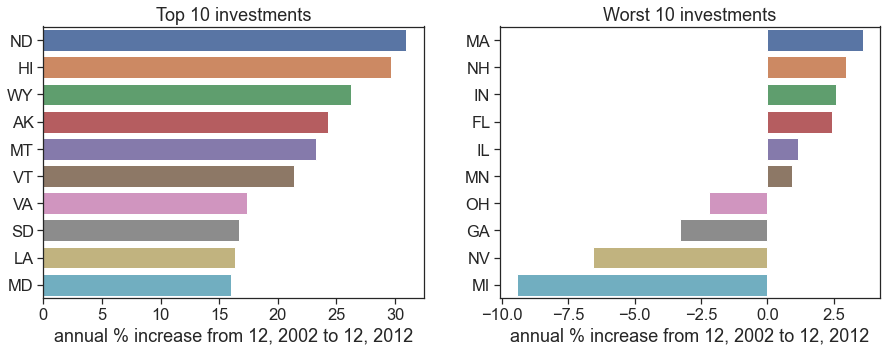

In [6]:
final_date=datetime(2012,12,1)
start_date=datetime(2002,12,1)
example2=calc_changes(df,start_date,final_date)
plot_best_and_worst(example2,start_date,final_date)

### All investment gains depend on the date of buying and date of selling. 
- We can see that the period from 2002 to 2012 shows different states as the top housing markets compared to the time period assesed above. Specifically, North Dakota, Hawaii, and Wyoming were the best investments. On the right, we can see 4 states that have negative return on investments. Terrible time to sell an asset in those states.
- The index fund only outperformed 20 states for this period, which means that the majority of housing markets were better investments. Also, this result tells us that we cannot generalize the result from above (i.e. an index fund can outperform a home purchase in a majority of states) for all time periods.

In [7]:
sum(example2<example2['S&P 500'])

20

## Section 3: How often has the S&P outcompeted the majority of housing markets?
Let's assume the investment period is 10 years because homeowners tend to sell a house 10 years after purchasing it, according to the National Association of Realtors.

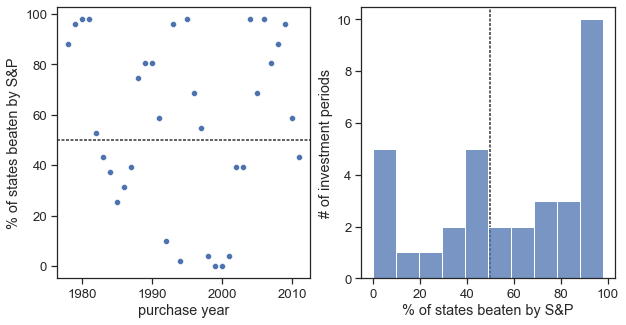

In [8]:
#generate a list of 15 year periods, with an increment of 1 year
period=10 
last_potential_year=df.index[-1].year
#include the last potential year
start_yrs=np.arange(df.index[0].year,last_potential_year-period+1)
stop_yrs=start_yrs+period
proportion=[]
#calculate the changes for each window
for i in range(len(start_yrs)):
    changes=calc_changes(df, '-'.join([str(start_yrs[i]),'01','01']), '-'.join([str(stop_yrs[i]), '01','01']))
    #calculate the proportion of rows less than the index fund
    proportion.append(np.mean(changes<changes['S&P 500']))

performance=pd.DataFrame({
    'start_year': start_yrs,
    'stop_year': stop_yrs,
    'percent': np.array(proportion)*100,
})
performance['period']=period
sns.set_theme(style='ticks', font_scale=1.2)
fig, ax= plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(data=performance, x='start_year', y='percent',
              ax=ax[0])
#horizontal line at 50
ax[0].axhline(y=50, color='.2', dashes=(2,1), zorder=0) 
ax[0].set_xlabel('purchase year')
ax[0].set_ylabel('% of states beaten by S&P')
sns.histplot(x=performance['percent'], bins=10, ax=ax[1])
#vertical line at 50
ax[1].axvline(x=50, color='.2', dashes=(2,1), zorder=0)
ax[1].set_xlabel('% of states beaten by S&P')
ax[1].set_ylabel('# of investment periods')
plt.show()

In [9]:
np.mean(performance['percent']>50)

0.5882352941176471

### The S&P 500 has outperformed the majority of housing markets 58.8% of the time
The graph on the left shows the percent of states that gave a lower return on investment compared to the S&P 500 as a function of the purchase year. 58.8% of the points are above the dashed line at 50, which means that the S&P 500 performed better than half or more states in 58.8% of these periods. This result is also visually apparent in the histogram, which shows the number of investment periods where the S&P 500 beat specific percentages of the states. The collectively area of the bars to the right of the dashed line is greater than the bars to the left.

## Section 4: Which states are least correlated with the S&P 500 and are therefore subject to less risk?
There is risk associated with any investment and those risks are not necessarily the same for real estate and index funds. Naturally, you might think that if you buy home it will not exposed to the same risks that the stock market is exposed to. But does the data support this hypothesis? The answer probably depends on location, similar to the answers in section 2.

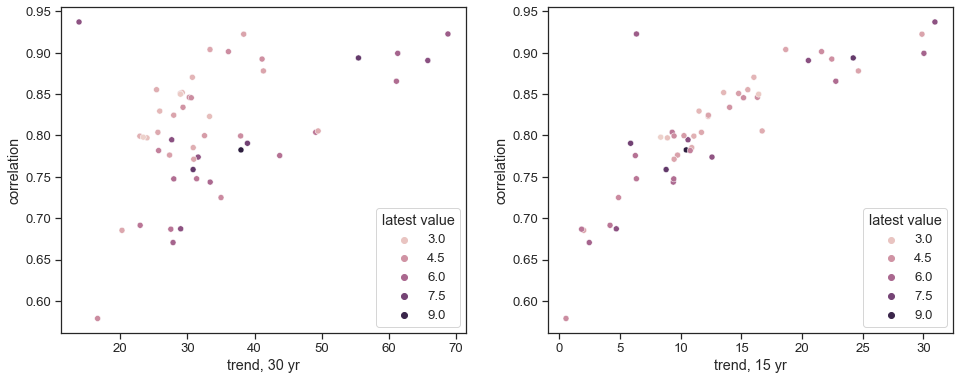

In [10]:
#identify which states are least correlated with the stock market
reg=linear_model.LinearRegression() # regression object
coeff=[]
r_squared=[]
# for all housing indices
for state in states_HPI.columns:
    #run linear regression against the S&P500 
    reg.fit(df[state].values.reshape(-1,1),df['S&P 500'])
    coeff.append(reg.coef_[0])
    r_squared.append(reg.score(df[state].values.reshape(-1,1),df['S&P 500']))

state_metrics=pd.DataFrame(
    {'beta': coeff,
     'correlation': r_squared,
     'latest value': df.iloc[-1,1:]
    },index=states_HPI.columns)
#calculate the average change in the last 30 years
#choose the last date that's available
final_date=df.index[-1]
start_date=final_date.replace(year=final_date.year-30) #subtract 30 years
state_metrics['trend, 30 yr']=calc_changes(df.drop('S&P 500',axis=1),start_date,final_date)
start_date=final_date.replace(year=final_date.year-15) #substract 15 years
state_metrics['trend, 15 yr']=calc_changes(df.drop('S&P 500',axis=1),start_date,final_date)
fig, ax= plt.subplots(1,2, figsize=(16,6))
sns.scatterplot(data=state_metrics, x='trend, 30 yr', y='correlation', 
            hue='latest value', ax=ax[0])
sns.scatterplot(data=state_metrics, x='trend, 15 yr', y='correlation',
           hue='latest value', ax=ax[1])
plt.show()

In [11]:
#what are the top 3 states with R squared at 0.75 or less?
state_metrics.loc[state_metrics['correlation']<0.75,'trend, 15 yr'].sort_values(ascending=False)[:3]

VT    9.420073
NH    9.381022
VA    6.339921
Name: trend, 15 yr, dtype: float64

### Vermont and New Hampshire have good returns and low correlation with the S&P 500 
In general, most states that have performed well over the last 15 years are correlated with the S&P 500. If you buy a home in Vermont or New Hampshire, you can be confident that the housing market performed at 9.4% increase over the last 15 years and it is not as correlated with the stock market as homes in other states.

# Depending on the location, an index fund is better than a home purchase
The decision to buy a home is often based on heuristics such as "Real estate is less risky than a mutual fund" or "Renting is just throwing away money instead of building wealth." Although these ideas have merit, the truth is that home prices in 2021 are higher than ever, which means a mortgage payment (along with taxes and potentially home owners insurance) is a huge amount of money and you could likely find cheaper rent. The money you save by renting could be better used as a nest egg that grows in the stock market through an index fund. Even if you are in a situation where a mortage would be equal to the rent you're willing to pay, the analysis in section 2 indicates that based on where you live, it may be better to invest in an index fund rather purchasing a home.
Additionally, the analysis in section 3 indicates that you do not automatically diversify your investment portfolio by putting some of your money toward a home and some of it into an index fund. Depending on your location, these assets are strongly correlated. If your goal is to mitigate risk, look specifically for those locations where the home price has not been historically correlated with the an index fund.
### Location, location, location. 
There are so many reasons location matters when deciding to buy a home. The analysis here gives us yet another reason: your money could earn more for you in an index fund than in a home. 
